# Simple example of a recurrent SLDS

In [1]:
import os
import pickle
import copy

import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(12345)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
color_names = ["windows blue", "red", "amber", "faded green"]
colors = sns.xkcd_palette(color_names)
sns.set_style("white")
sns.set_context("talk")

import ssm
from ssm.util import random_rotation, find_permutation

In [2]:
# Global parameters
T = 10000
K = 4
D_obs = 10
D_latent = 2

In [3]:
# Simulate the "nascar" data
def make_nascar_model():
    As = [random_rotation(D_latent, np.pi/24.),
      random_rotation(D_latent, np.pi/48.)]

    # Set the center points for each system
    centers = [np.array([+2.0, 0.]),
           np.array([-2.0, 0.])]
    bs = [-(A - np.eye(D_latent)).dot(center) for A, center in zip(As, centers)]

    # Add a "right" state
    As.append(np.eye(D_latent))
    bs.append(np.array([+0.1, 0.]))

    # Add a "right" state
    As.append(np.eye(D_latent))
    bs.append(np.array([-0.25, 0.]))

    # Construct multinomial regression to divvy up the space
    w1, b1 = np.array([+1.0, 0.0]), np.array([-2.0])   # x + b > 0 -> x > -b
    w2, b2 = np.array([-1.0, 0.0]), np.array([-2.0])   # -x + b > 0 -> x < b
    w3, b3 = np.array([0.0, +1.0]), np.array([0.0])    # y > 0
    w4, b4 = np.array([0.0, -1.0]), np.array([0.0])    # y < 0
    Rs = np.row_stack((100*w1, 100*w2, 10*w3,10*w4))
    r = np.concatenate((100*b1, 100*b2, 10*b3, 10*b4))
    
    true_rslds = ssm.SLDS(D_obs, K, D_latent, 
                      transitions="recurrent_only",
                      dynamics="diagonal_gaussian",
                      emissions="gaussian_orthog",
                      single_subspace=True)
    true_rslds.dynamics.mu_init = np.tile(np.array([[0, 1]]), (K, 1))
    true_rslds.dynamics.sigmasq_init = 1e-4 * np.ones((K, D_latent))
    true_rslds.dynamics.As = np.array(As)
    true_rslds.dynamics.bs = np.array(bs)
    true_rslds.dynamics.sigmasq = 1e-4 * np.ones((K, D_latent))
    
    true_rslds.transitions.Rs = Rs
    true_rslds.transitions.r = r
    
    true_rslds.emissions.inv_etas = np.log(1e-2) * np.ones((1, D_obs))
    return true_rslds

# Sample from the model
true_rslds = make_nascar_model()
z, x, y = true_rslds.sample(T=T)

In [4]:
# Fit an rSLDS with its default initialization, using Laplace-EM with a structured variational posterior
rslds = ssm.SLDS(D_obs, K, D_latent,
             transitions="recurrent_only",
             dynamics="diagonal_gaussian",
             emissions="gaussian_orthog",
             single_subspace=True)
rslds.initialize(y)
q_elbos_lem, q_lem = rslds.fit(y, method="laplace_em",
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=100, alpha=0.0)
xhat_lem = q_lem.mean_continuous_states[0]
rslds.permute(find_permutation(z, rslds.most_likely_states(xhat_lem, y)))
zhat_lem = rslds.most_likely_states(xhat_lem, y)

# store rslds
rslds_lem = copy.deepcopy(rslds)

Initializing with an ARHMM using 25 steps of EM.


In [5]:
# Fit an rSLDS with its default initialization, using BBVI with a structured variational posterior
rslds = ssm.SLDS(D_obs, K, D_latent, 
             transitions="recurrent_only",
             dynamics="diagonal_gaussian",
             emissions="gaussian_orthog",
             single_subspace=True)
rslds.initialize(y)

q_elbos_svi, q_svi = rslds.fit(y, method="bbvi",
                               variational_posterior="tridiag",
                               initialize=False, num_iters=1000)

# Get the posterior mean of the continuous states
xhat_svi = q_svi.mean[0]

# Find the permutation that matches the true and inferred states
rslds.permute(find_permutation(z, rslds.most_likely_states(xhat_svi, y)))
zhat_svi = rslds.most_likely_states(xhat_svi, y)

Initializing with an ARHMM using 25 steps of EM.


Text(0, 0.5, 'ELBO')

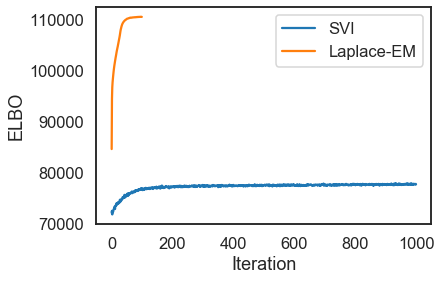

In [6]:
# Plot some results
plt.figure()
plt.plot(q_elbos_svi, label="SVI")
plt.plot(q_elbos_lem[1:], label="Laplace-EM")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("ELBO")

In [7]:
# Helper functions for plotting results
def plot_trajectory(z, x, ax=None, ls="-"):
    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    for start, stop in zip(zcps[:-1], zcps[1:]):
        ax.plot(x[start:stop + 1, 0],
                x[start:stop + 1, 1],
                lw=1, ls=ls,
                color=colors[z[start] % len(colors)],
                alpha=1.0)

    return ax


def plot_most_likely_dynamics(model,
    xlim=(-4, 4), ylim=(-3, 3), nxpts=20, nypts=20,
    alpha=0.8, ax=None, figsize=(3, 3)):
    
    K = model.K
    assert model.D == 2
    x = np.linspace(*xlim, nxpts)
    y = np.linspace(*ylim, nypts)
    X, Y = np.meshgrid(x, y)
    xy = np.column_stack((X.ravel(), Y.ravel()))

    # Get the probability of each state at each xy location
    z = np.argmax(xy.dot(model.transitions.Rs.T) + model.transitions.r, axis=1)

    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)

    for k, (A, b) in enumerate(zip(model.dynamics.As, model.dynamics.bs)):
        dxydt_m = xy.dot(A.T) + b - xy

        zk = z == k
        if zk.sum(0) > 0:
            ax.quiver(xy[zk, 0], xy[zk, 1],
                      dxydt_m[zk, 0], dxydt_m[zk, 1],
                      color=colors[k % len(colors)], alpha=alpha)

    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

    plt.tight_layout()

    return ax

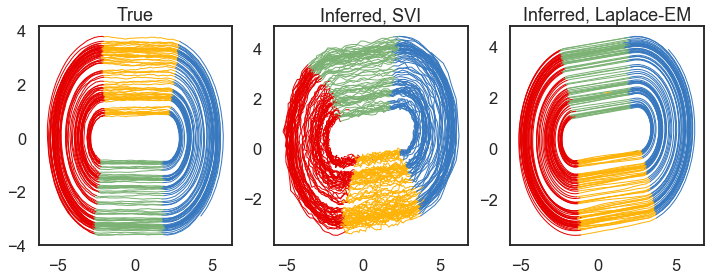

In [8]:
plt.figure(figsize=[10,4])
ax1 = plt.subplot(131)
plot_trajectory(z, x, ax=ax1)
plt.title("True")
ax2 = plt.subplot(132)
plot_trajectory(zhat_svi, xhat_svi, ax=ax2)
plt.title("Inferred, SVI")
ax3 = plt.subplot(133)
plot_trajectory(zhat_lem, xhat_lem, ax=ax3)
plt.title("Inferred, Laplace-EM")
plt.tight_layout()

Text(0.5, 1, 'Inferred Dynamics, SVI')

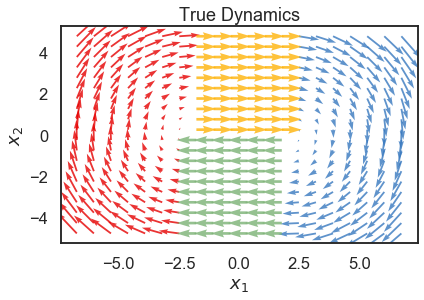

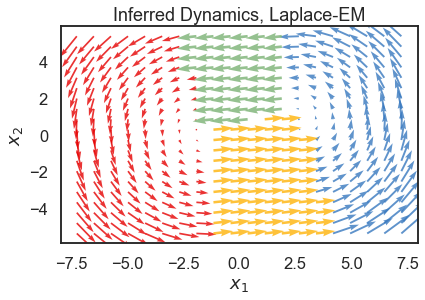

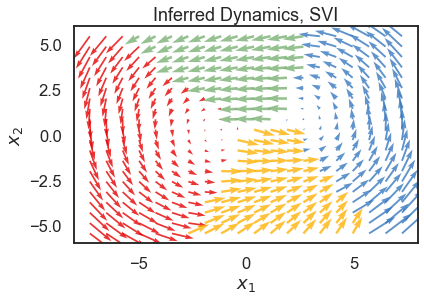

In [9]:
plt.figure(figsize=(6,4))
ax = plt.subplot(111)
lim = abs(x).max(axis=0) + 1
plot_most_likely_dynamics(true_rslds, xlim=(-lim[0], lim[0]), ylim=(-lim[1], lim[1]), ax=ax)
plt.title("True Dynamics")

plt.figure(figsize=(6,4))
ax = plt.subplot(111)
lim = abs(xhat_lem).max(axis=0) + 1
plot_most_likely_dynamics(rslds_lem, xlim=(-lim[0], lim[0]), ylim=(-lim[1], lim[1]), ax=ax)
plt.title("Inferred Dynamics, Laplace-EM")

plt.figure(figsize=(6,4))
ax = plt.subplot(111)
lim = abs(xhat_svi).max(axis=0) + 1
plot_most_likely_dynamics(rslds, xlim=(-lim[0], lim[0]), ylim=(-lim[1], lim[1]), ax=ax)
plt.title("Inferred Dynamics, SVI")